# Preprocessing text-mining
Ce notebook a pour objectif le traitement des textes obtenus par océrisation des images.
L'objectif est donc d'obtenir, pour chaque image (=document) un texte amélioré, permettant d'alimenter des modèles de Machine learning.

La base de texte choisie est l'ocr collectif: comme cela a été vu procédément, il contient le plus grand nombre de données (environ 398k documents sur les 400k possibles) et les informations contenues semblent identiques à celles des documents individuels).

Dans ce notebook, on va donc créer un dataframe qui aura ce format (les colonnes ocr_x sont des colonnes obtenues après traitement de raw_ocr):

| document_id (index) | raw_ocr | ocr_1 |...| ocr_n | label 

En fin de notebook, il sera ainsi possible de créer les Dataframes X (ocr_x) et y (label) qui permettront d'alimenter les modèles.

La gestion du test_train_split est faite en début de notebook, en respectant la répartition définie dans le dataset RVL-CDIP.

# 1. Chargement des données

In [3]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
project_path = '/Users/couet-lannesandre/Documents/' # à modifier par chacun en fonction de son arborescence

data_path = os.path.join(project_path, 'data')
raw_data_path = os.path.join(data_path, 'raw')
processed_data_path = os.path.join(data_path, 'processed')
extracted_data_path = os.path.join(data_path, 'extracted')

raw_rvl_cdip_path = os.path.join(raw_data_path, 'RVL-CDIP')
rvl_cdip_images_path = os.path.join(raw_rvl_cdip_path, 'images')
rvl_cdip_labels_path = os.path.join(raw_rvl_cdip_path, 'labels')

iit_cdip_images_path = os.path.join(raw_data_path, 'IIT-CDIP', 'images')
iit_cdip_xmls_path = os.path.join(raw_data_path, 'IIT-CDIP', 'xmls')

In [5]:
documents_file = os.path.join(extracted_data_path, 'df_documents.parquet')
coll_xml_file = os.path.join(extracted_data_path, 'df_iit_cdip_coll_xml_ltdlwocr_features.parquet')
documents = pd.read_parquet(documents_file)\
    .set_index("document_id")\
    [["label", "data_set"]]
raw_ocr = pd.read_parquet(coll_xml_file)\
    .set_index("document_id")\
    [["ocr_output"]]\
    .rename(columns={"ocr_output": "raw_ocr"})
df = raw_ocr.join(documents, how="inner")

display(df.head())
df.groupby("data_set").count()

,raw_ocr,label,data_set
document_id,,,
aaa06d00,"I\nVvtts Research, 5 (1986) 131-144\nElsevier\...",6,test
aaa08d00,"""i1AR-13-97 THU ]7t59 RKH PUBLIC RELATIONS FAX...",9,train
aaa09e00,l\nCOVINGTON &amp; BUFR'LING~\n1201 PENNSYLVAN...,11,val
aaa10c00,"Chaikin, Karen\nFrom: Chaikin, Karen\nSent: Tu...",2,train
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train


,raw_ocr,label
data_set,,
test,38706,39805
train,309242,318385
val,38706,39820


On supprime les valeurs pour lesquelles raw_ocr est à na (pour rappel, il s'agit majoritairement de colonnes dont le label vaut "folder"). Cela veut dire qu'il faudra s'interroger sur la suppression totale de ces catégories, ou sur la création d'une catégorie unknown) ==> 
A ta main @Alexis

In [6]:
# TODO SUR GRAPHE: insérer les couleurs définies par Camille (train test val)

Text(0.5, 0.98, 'Distributions des différents labels')

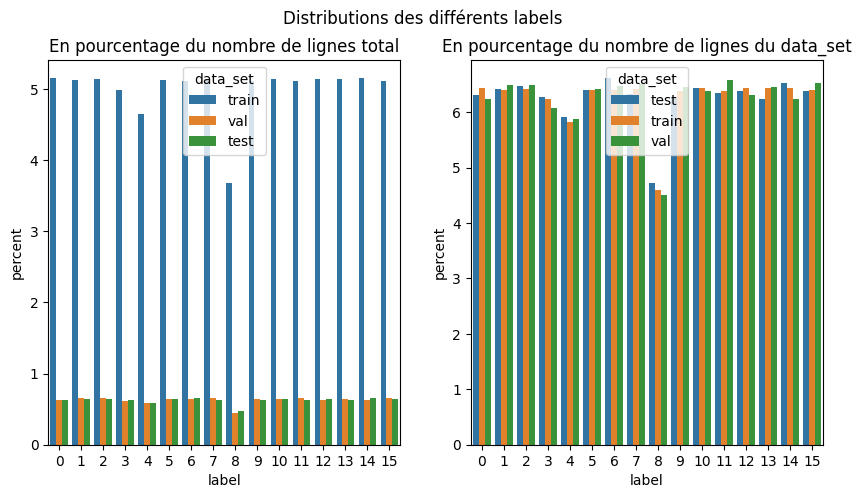

In [6]:
df = df.dropna()
# df.drop(columns="raw_ocr").groupby("data_set").value_counts()
plt.figure(figsize =(10, 5))
plt.subplot(121)
sns.countplot(
    data = df,
    x = "label",
    hue = "data_set",
    stat="percent"

)
plt.title("En pourcentage du nombre de lignes total")
plt.subplot(122)

# je n'ai pas réussi à faire ce graphe avec seaborn nativement...
df_grouped = (
    df.groupby(["data_set", "label"])
    .size()
    .reset_index(name="count")
)
df_grouped["percent"] = df_grouped.groupby("data_set")["count"].transform(lambda x: x / x.sum() * 100)

sns.barplot(
    data=df_grouped,
    x="label",
    y="percent",
    hue="data_set"
)
plt.title("En pourcentage du nombre de lignes du data_set")
plt.suptitle("Distributions des différents labels")

Les distributions sont globalement uniformes, avec un affaiblissement des catégories 8, 4 et 3.

In [7]:
train = df[df.data_set == "train"].drop(columns="data_set")
test = df[df.data_set == "test"].drop(columns="data_set")
val = df[df.data_set == "val"].drop(columns="data_set")

A partir de maintenant, nous ne travaillons que sur train

# 2. Etude manuelle des défauts d'OCR

In [9]:
# OPERATION PREALABLE // A RETIRER QUAND PROCESSUS STABLE

train = train[:1000]

In [10]:
# Pour faciliter les premières analyses, on va se limiter aux ocr dont le nombre de caractères n'est pas trop long:
train_short_ocrs = train[train.raw_ocr.str.len()<500]
# len(train_short_ocrs) @=197

In [8]:
# La fonction ocr_insight permet d'afficher une image et son texte océrisé côte à côte.
# Cela va nous permettre de mieux comprendre certains ocr
from PIL import Image
import io
import base64
from IPython.display import display, HTML

image_paths = pd.read_parquet(documents_file)\
    .set_index("document_id")\
    [["rvl_image_path", "iit_image_path"]]

def display_tiff_pages(tiff_path):
    img = Image.open(tiff_path)

    for i in range(img.n_frames):
        img.seek(i)  # Aller à la page i
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        
        html_blocks.append(f'<img src="data:image/png;base64,{img_b64}" style="width: 60%; margin-bottom: 20px;" />')

    display(HTML("<br>".join(html_blocks)))




def get_image(document_id):
    """Return a BytesIO png converted image, which will be compatible with html display"""
    image_path = os.path.join(
        data_path,
        image_paths.loc[document_id, "iit_image_path"]
    )
    
    html_blocks = []
    img = Image.open(image_path)
    
    for i in range(img.n_frames):
        img.seek(i)  # Aller à la page i
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        
        html_blocks.append(f'<img src="data:image/png;base64,{img_b64}" />')
    return html_blocks
    
def ocr_insight(document_id):
    text = train.loc[document_id, "raw_ocr"]
    raw_text = repr(text)
    interpretated_text = '\n'.join([
        f"<p>{line}</p>"
        for line in text.splitlines()])
    image = get_image(document_id)
    
    html_code = f"""
    <div style="display: flex; align-items: center;">
      <div style="width: 40%; max-height: 600px; overflow-y: auto">
        <p><strong>Texte brut :</strong></p>
        <p>{raw_text}</p>
        <p><strong>Texte interprété :</strong></p>
        {interpretated_text}
      </div>
      <div style="width: 60%"; max-height: 600px>
        {"<br>".join(get_image(document_id))}
    </div>@
    </div>
    """
#      <img src="data:image/png;base64,{image}" style="width: 60%; margin-right: 20px;">
    display(HTML(html_code))

In [9]:
ocr_insight(train_short_ocrs.index[0])


NameError: name 'train_short_ocrs' is not defined

<span style="color:blue">**Analyse :**</span>
- pgNbr inutile
- une typo (6ring qui est sans doute bring)

In [ ]:
ocr_insight(train_short_ocrs.index[1])


<span style="color:blue">**Analyse :**</span>
- OCR inexploitable (aucune information captée du fait de l'écriture manuscrite)
- nombre de pages (2)  difficile à interpréter (le document ne semble en contenir qu'une)
- le nombre de page est un artéfact de la numérisation ==> a supprimer car ce n'est pas une information provenant du document

In [ ]:
ocr_insight(train_short_ocrs.index[2])


<span style="color:blue">**Analyse :**</span>
- OCR parfait (hors pgNbr)

In [ ]:
ocr_insight(train_short_ocrs.index[3])


<span style="color:blue">**Analyse :**</span>
- OCR globalement bon (perturbation sur les taches et manques de précision: "Rw" pour "Rev",...
- texte manuscrit ignorées
- ordre de lecture naturel non respecté (pour le tableau approvals, on parcourt la premiere colonne jusq'a 3 puis les entetes de colonne, puis la suite de la premiere colonne
- artéfact "f li"
- toujours le pgNbr

In [4]:
ocr_insight(train_short_ocrs.index[4])


NameError: name 'ocr_insight' is not defined

<span style="color:blue">**Analyse :**</span>
- non détection du texte blanc sur fond noir
- non détection du texte dans l'encart en bas à gauche (comme si un traitement par lignesavait choisi de ne pas le traiter)
- assez peu de mauvaises détections
- textes du bas souffrant d'erreurs: nicmine pour nicotine, mdds pour milds, rigarette pour cigarette
- toujours le pgNbr

In [5]:
# @Alexis, je te laisse continuer si tu veux...

## Conclusion
Pour les traitements à venir, nous avons observé qu'il pourrait être utile:
- retirer toutes les informations relatives au pgNbr=x;
- "déséchapper" tous les caractères html (&lt, &amp, ...) // non vu ici mais est facilement identifié avec train[train.raw_ocr.str.contains("&lt")]
- corriger avec un outil spécialisé les erreurs d'océrisation, avec si possible prise en compte du contexte;
- ne pas espérer avoir de résultats sur les textes écrits à la main
- de supprimer les caractères spéciaux, voire les lignes contenant plus de ces caractères erronés que de caractères alphanumériques;
- de conserver aussi longtemps que possible les lignes, qui sont en général cohérentes;
- de considérer, in fine comme na les documents qui ne contiennent plus assez d'information (nombre de mots trop faible)

# 3. Vérification d'hypothèses

## 3.1. Isolement des "Handwritten" par un pattern spécifique
On a remarqué que les ocr correspondant à des handwritten étaient souvent formés de la même manière. Nous allons essayer de trouver un pattern qui permette de les isoler avec un bon score d'accuracy.
Nous travaillons sur le jeu de données train, pour éviter toute fuite de données.

In [11]:
df_hw_train = df[(df.label == 3) & (df.data_set == "train")]
df_others_train = df[(df.label != 3) & (df.data_set == "train")]

In [12]:
df_hw_train.head(10)

,raw_ocr,label,data_set
document_id,,,
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train
aaa13d00,-4~&amp;4\n9~j~ 6~ 6/ 90 ~a\n33 39 /o\n3i-3y 3...,3,train
aaa90d00,"y P /G ~ ""I'1,11111 I,IIll g,ll 11,11,\n\npwo~...",3,train
aab60d00,LLZS TSLLS\n\npgNbr=1\ncz ~&gt;io-z~\n\n\npgNbr=2,3,train
aab90d00,"~Q4\n`\nAre- Z7/a,:2-\nL,3,fl,ff\n\npgNbr=1\nl...",3,train
aac65d00,"]1Ja IL~ ~'~~* L~\n\n3~_ !fI.: - .\n,\nFF,/tit...",3,train
aad56d00,"Juab Middle School\n475 East 600 North\nNephi,...",3,train
aae21d00,"~~ 1144 ollk, Os/lboft (\nr~ ""~ /9 9 ~'\n\npgN...",3,train
aaf70d00,40009 3405\n~/~! d.r // v ~/ ''~!/\ns ~t~ '~!l...,3,train


In [ ]:
# On va verifier combien de documents contiennent plus de 5 mots de deux lettres.


In [19]:
import re

# A améliorer pour prendre en compte les lignes
# sans doute trop brutal / il faudra le réviser sur d'autres versions ultérieures?
def basic_word_filter(text):
    if not text:
        return text
    text = text.lower()
    # Attention, c'est brutal, ca supprime tous les chiffres aussi...
    word_regex = re.compile(r'[a-z]{4,}')
    text = ' '.join(word_regex.findall(text))
    
    return text

In [17]:
def word_count(text):
    words = text.split(' ')
    return len(words)
    
text = "pgnbr vt rr zlle am ln oajl amp pgnbr"

In [15]:
def handwritten_filter(text):
    """says if a text is handwritten or not"""
    if word_count(basic_word_filter(text)) < 15:
        return True
    else:
        return False

In [13]:
X_train = df[df.data_set == "train"].drop(columns=["label", "data_set"])
y_train = df[df["data_set"] == "train"]["label"] == 3

In [20]:
y_pred = X_train.raw_ocr.apply(handwritten_filter)

In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.91      0.94    289953
        True       0.34      0.66      0.45     19289

    accuracy                           0.90    309242
   macro avg       0.66      0.79      0.70    309242
weighted avg       0.94      0.90      0.91    309242



In [21]:
wc_results = X_train.raw_ocr.apply(basic_word_filter).apply(word_count)

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
sns.histplot(wc_results.values, bins = [0,1,2,3,4,5, 10, 15, 20, 30, 40, 50,100]);
# plt.xlim(0, 10);

In [22]:
df_hw_train[df_hw_train.raw_ocr.apply(basic_word_filter).apply(word_count) <10]

,raw_ocr,label,data_set
document_id,,,
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train
aaa90d00,"y P /G ~ ""I'1,11111 I,IIll g,ll 11,11,\n\npwo~...",3,train
aab60d00,LLZS TSLLS\n\npgNbr=1\ncz ~&gt;io-z~\n\n\npgNbr=2,3,train
aab90d00,"~Q4\n`\nAre- Z7/a,:2-\nL,3,fl,ff\n\npgNbr=1\nl...",3,train
aac65d00,"]1Ja IL~ ~'~~* L~\n\n3~_ !fI.: - .\n,\nFF,/tit...",3,train
...,...,...,...
zzo21d00,THE ALAN FIKES\n704 Barry Avenue\nMuscai; ;{ !...,3,train
zzp21d00,",01P J. Reymoc,os -7.- o wo d,.\nN\n-,~7/OZ m\...",3,train
zzp40d00,"~\n\npgNbr=1\n,\n\n;\ni4 s r~ ~\nit L F'\n0 Ir...",3,train


In [23]:
df_others_train[df_others_train.raw_ocr.apply(basic_word_filter).apply(word_count) <10]

,raw_ocr,label,data_set
document_id,,,
aab47c00,Jan\n01\n15\nJan-\n29\nJan-\n12\nFeb-\n26\nFeb...,12,train
aab80c00,"xow 100's #i20\nTime 9/20/82\nLTS, Inc.\nAdvcr...",4,train
aab99e00,5 9\n3 { ~7353\nI;}i~]ifj~Saja~~7lda~yffFff~lf...,7,train
aac05f00,N\nO\nO\nQ\npgNbr=1,8,train
aad15c00,.~-.1 qwipy l/''~I~T =~\n202S61S031\n\npgNbr=1,8,train
...,...,...,...
zzw97d00,45 ax3c~y sxv~~'q\s)\niii\n\npgNbr=1,8,train
zzx32d00,"tC;bTES690Z\nR\n11\n\nIfi,~diil~F'\nI\nA\n19\n...",8,train
zzy05c00,CERTIFICATIONS\n2076734459\n\npgNbr=1,8,train


In [26]:
len(df_others_train)

289953

In [ ]:
# Avec un filtre à 10 mots, on arrive a identifier environ 15500 handwritten sur 20000
# dans le même temps, on identifierait à tort 16665 documents sur 290000 


# 4. Application des traitements

## 3.1. Création ocr_1
Ce premier pipeline de traitement permettra d'arriver à la création de la colonne ocr_1

### 3.1.1. Suppression des pagesNbr

In [39]:
import re
pg_regex = re.compile(r'pgNbr=[0-9]+')
type(pg_regex)

re.Pattern

In [ ]:
df.head(10)

In [32]:
def count_pgNbr(text):
    return len(pg_regex.findall(text))
# comptabilisation du nombre de pgNbr:

def remove_pgNbr(text):
    text = pg_regex.sub('', text)
    return text

avant = df.raw_ocr.apply(count_pgNbr).sum()
df["ocr_tmp"] = df.raw_ocr.apply(remove_pgNbr)
apres = df.ocr_tmp.apply(count_pgNbr).sum()
print(avant, apres)

1868788 0


### 3.1.2. Déséchappement html

In [33]:
import html
def unescape_html(text):
    if not text:
        return text
    return html.unescape(text)

avant = df.ocr_tmp.str.contains("&lt;").sum()
df.loc[:,"ocr_tmp"] = df.ocr_tmp.apply(unescape_html)
apres = df.ocr_tmp.str.contains("&lt;").sum()
avant, apres

(86917, 1)

### 3.1.3. Correction OCR
Nous allons pour cela utiliser l'outil jamspell

In [ ]:
# Le but ici est d'utiliser une librairie de correction de texte océrisé nommée jamspell
# L'emploi de cette bibliothèque peut se faire soit avant, soit après les traitements réalisés au 1.
# Nous utiliserons les 2 approches, pour réaliser 2 colonnes:
# - cleaned_ocr_jamspell_first 
# - cleaned_ocr_jamspell_last

In [ ]:
import jamspell
jamspell_model_path = os.path.join(project_path, 'models', 'jamspell', 'en.bin')
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel(jamspell_model_path)
def apply_jamspell(text):
    if not text:
        return text
    return corrector.FixFragment(text)
# avant = df.ocr_tmp.str.contains("&lt;").sum()
df.loc[:,"ocr_tmp"] = df.ocr_tmp.apply(apply_jamspell)
# apres = df.ocr_tmp.str.contains("&lt;").sum()
# avant, apres

In [ ]:
df.head(20)

### 3.1.4 Suppression des caractères spéciaux et des séquences ne correspondant pas à des informations

In [34]:
import re

# A améliorer pour prendre en compte les lignes
# sans doute trop brutal / il faudra le réviser sur d'autres versions ultérieures?
def basic_word_filter(text):
    if not text:
        return text
    text = text.lower()
    # Attention, c'est brutal, ca supprime tous les chiffres aussi...
    word_regex = re.compile(r'[a-z]{2,}')
    text = ' '.join(word_regex.findall(text))
    
    return text
df["ocr_tmp"] = df.ocr_tmp.apply(basic_word_filter)

### 3.1.5. Filtrage des stop_words

In [35]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
nltk.download('punkt_tab')
# Télécharger les ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /Users/couet-
[nltk_data]     lannesandre/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/couet-
[nltk_data]     lannesandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/couet-
[nltk_data]     lannesandre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
#Liste des stop words en anglais
stop_words = set(stopwords.words('english'))

# Fonction pour nettoyer une phrase
def remove_stopwords(text):
    if pd.isnull(text):  # gestion des valeurs manquantes
        return ""
    words = word_tokenize(text.lower())
    filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return " ".join(filtered)

# Application sur la colonne raw_ocr
df['raw_ocr_clean'] = df['ocr_tmp'].apply(remove_stopwords)

# Affichage
print(df[['ocr_tmp', 'raw_ocr_clean']])


                                                       ocr_tmp  \
document_id                                                      
aaa06d00     vvtts research elsevier vrr structural protein...   
aaa08d00     ar thu rkh public relations fax no thursday ma...   
aaa09e00     covington bufr ling pennsylvania avenue wv box...   
aaa10c00     chaikin karen from chaikin karen sent tuesday ...   
aaa11d00                                 vt rr zlle am ln oajl   
...                                                        ...   
zzz77d00                                                         
zzz83c00     philip morris inter office correspondence date...   
zzz85c00     panies management corporation incorporated dat...   
zzz86c00     warning the surgeon general nas determined tha...   
zzz97c00     ron from turner alvin to bowles regina martin ...   

                                                 raw_ocr_clean  
document_id                                                     
aaa06d00   

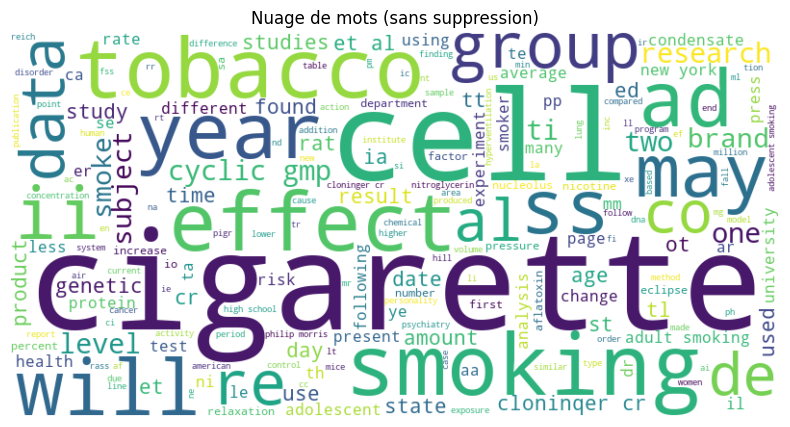

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pour affichage dans le notebook (spécifique Jupyter sur macOS)
%matplotlib inline

# Préparer le texte (limité à 500 000 caractères pour éviter les crashs)
text = " ".join(df['ocr_tmp'].dropna().astype(str).tolist())[:500000]

# Générer le nuage sans stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Affichage
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots (sans suppression)")
plt.show()




In [34]:
df.head()

,raw_ocr,label,data_set,ocr_tmp,raw_ocr_clean
document_id,,,,,
aaa06d00,"I\nVvtts Research, 5 (1986) 131-144\nElsevier\...",6,test,vvtts research elsevier vrr structural protein...,vvtts research elsevier vrr structural protein...
aaa08d00,"""i1AR-13-97 THU ]7t59 RKH PUBLIC RELATIONS FAX...",9,train,ar thu rkh public relations fax no thursday ma...,ar thu rkh public relations fax thursday march...
aaa09e00,l\nCOVINGTON &amp; BUFR'LING~\n1201 PENNSYLVAN...,11,val,covington bufr ling pennsylvania avenue wv box...,covington bufr ling pennsylvania avenue wv box...
aaa10c00,"Chaikin, Karen\nFrom: Chaikin, Karen\nSent: Tu...",2,train,chaikin karen from chaikin karen sent tuesday ...,chaikin karen chaikin karen sent tuesday novem...
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train,vt rr zlle am ln oajl,vt rr zlle ln oajl


### 3.1.6. Application du Pipeline et création d'ocr_1

In [38]:
# Todo
def clean_ocr_1(text):
    text = remove_page_number(text)
    text = unescape_html(text)
    text = apply_jamspell(text)
    text = basic_word_filter(text)
    text = remove_stopwords(text)
    
    # ...
    return text
if "ocr_1" in train.columns:
    train.drop(columns="ocr_1", inplace=True)
train.insert(
    loc=1,
    column="ocr_1",
    value=train["raw_ocr"].apply(clean_ocr_1),
    allow_duplicates=False
)

NameError: name 'remove_page_number' is not defined

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Séparer les jeux
train_df = df[df['data_set'] == 'train']
val_df   = df[df['data_set'] == 'val']
test_df  = df[df['data_set'] == 'test']  # facultatif pour l’instant

# 3. Features et labels
X_train = train_df['ocr_tmp']
y_train = train_df['label']

X_val = val_df['ocr_tmp']
y_val = val_df['label']

# 4. Vectorisation TF-IDF sur le train uniquement
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect   = vectorizer.transform(X_val)


In [38]:
 #Modèles à tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()}


### 3.1.7. Analyse des résultats obtenus

In [39]:
#Entraînement et évaluation
for name, model in models.items():
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_val_vect)
    print(f"\n--- {name} ---")
    print(classification_report(y_val, y_pred))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2411
           1       0.82      0.73      0.77      2513
           2       0.95      0.91      0.93      2515
           3       0.62      0.76      0.68      2352
           4       0.79      0.73      0.76      2273
           5       0.76      0.73      0.75      2485
           6       0.84      0.91      0.87      2508
           7       0.94      0.92      0.93      2516
           8       0.63      0.81      0.71      1743
           9       0.81      0.81      0.81      2495
          10       0.83      0.82      0.83      2471
          11       0.86      0.85      0.86      2548
          12       0.76      0.75      0.75      2445
          13       0.93      0.90      0.91      2497
          14       0.97      0.98      0.97      2412
          15       0.79      0.76      0.77      2522

    accuracy                           0.82     387

In [46]:
from sklearn.metrics import classification_report

# Dictionnaire pour stocker les métriques
scores = {}

for name, model in models.items():
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_val_vect)
    print(f"\n--- {name} ---")
    print(classification_report(y_val, y_pred))

    # Stockage des métriques
    report = classification_report(y_val, y_pred, output_dict=True)
    scores[name] = {
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }





--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2411
           1       0.82      0.73      0.77      2513
           2       0.95      0.91      0.93      2515
           3       0.62      0.76      0.68      2352
           4       0.79      0.73      0.76      2273
           5       0.76      0.73      0.75      2485
           6       0.84      0.91      0.87      2508
           7       0.94      0.92      0.93      2516
           8       0.63      0.81      0.71      1743
           9       0.81      0.81      0.81      2495
          10       0.83      0.82      0.83      2471
          11       0.86      0.85      0.86      2548
          12       0.76      0.75      0.75      2445
          13       0.93      0.90      0.91      2497
          14       0.97      0.98      0.97      2412
          15       0.79      0.76      0.77      2522

    accuracy                           0.82     387

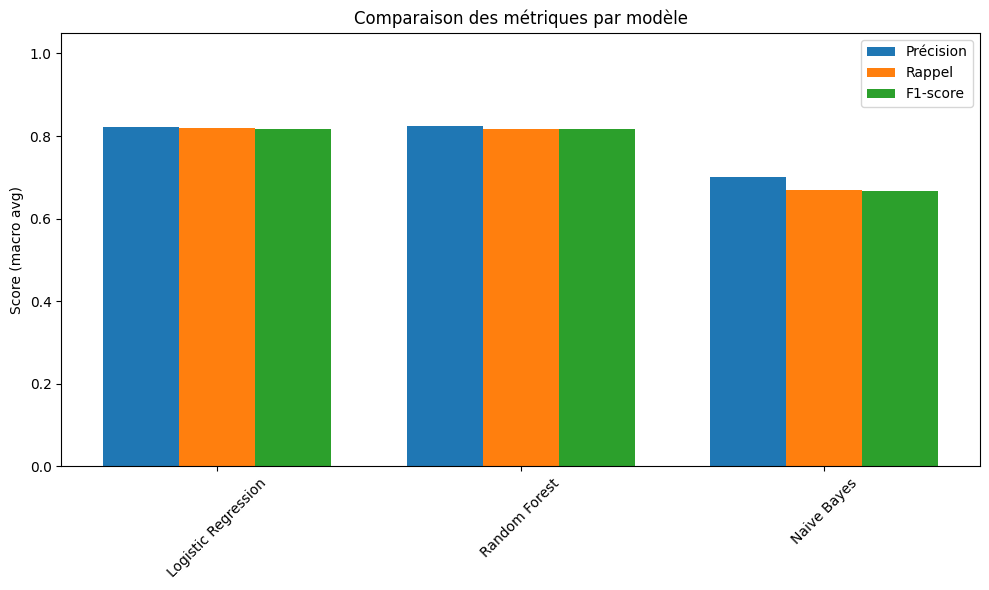

In [47]:
import matplotlib.pyplot as plt

# Extraire les métriques
labels = list(scores.keys())
precision = [scores[model]['precision'] for model in labels]
recall = [scores[model]['recall'] for model in labels]
f1 = [scores[model]['f1-score'] for model in labels]

x = range(len(labels))
width = 0.25

# Graphique
plt.figure(figsize=(10, 6))
plt.bar([p - width for p in x], precision, width=width, label='Précision')
plt.bar(x, recall, width=width, label='Rappel')
plt.bar([p + width for p in x], f1, width=width, label='F1-score')

plt.xticks(x, labels, rotation=45)
plt.ylabel("Score (macro avg)")
plt.title("Comparaison des métriques par modèle")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
!pip install tensorflow-macos)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encodage des labels (si ce n’est pas encore fait)
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)

# Définition du modèle MLP
model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vect.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(set(y_train_enc)), activation='softmax')  # Softmax pour multi-classe
])

model_mlp.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement
model_mlp.fit(X_train_vect.toarray(), y_train_enc,
              epochs=5, batch_size=32,
              validation_data=(X_val_vect.toarray(), y_val_enc))


zsh:1: parse error near `)'


NameError: name 'y_train' is not defined

In [42]:

# Créer le chemin vers Documents
import os

home = os.path.expanduser("~")
documents_path = os.path.join(home, "Documents")

# Sauvegarder les fichiers dans Documents
train_df.to_csv(os.path.join(documents_path, "train_df.csv"), index=False)
test_df.to_csv(os.path.join(documents_path, "test_df.csv"), index=False)
val_df.to_csv(os.path.join(documents_path, "val_df.csv"), index=False)

print("✅ Fichiers enregistrés dans ton dossier Documents !")


✅ Fichiers enregistrés dans ton dossier Documents !
